In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import json
import seaborn as sns
from collections import Counter
import nltk
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [4]:
yelp = pd.read_csv("yelp_balanced.csv")
yelp.head()

,Unnamed: 0,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,111089,S3r97tHMkzR4O-tiIIzwOQ,r0GLQAawvHXUd-xZow-fWQ,mzREMIknfmagJugibXrCsQ,4,2017-04-14,"Food is tasty, it's usually busy, but there al...",0,0,0
1,674606,lZTYcQXntUsLptcWCqyhmg,bDs5_ek9esUkgxFm1jFxfg,aZG9Hp8fdgzq37iuB1QTYg,1,2017-10-01,Probably one of the worst experiences I've eve...,1,0,0
2,3329480,sStohXbOEdPyrutK3zJSmg,mus1d8cMxuEJmP0zfV19hg,I4Nr-MVc26qWr08-S3Q1ow,4,2017-01-19,I was looking for a place to grab a quick bite...,0,0,0
3,3641542,Pvw7lbeyGGLVALvK0DwgDA,qrwH8z4nNUabqlsnwNoDCg,vAbRNF0hJt91oCUpm_sdKw,3,2014-01-09,"Meh, fish was a bit rubbery for $34 swordfish....",1,0,0
4,2054056,XWN8BVvLwcmgEW6xZuOKpg,cYvO88wNlRc_gd03caBZ7Q,sNVGdeOPeitJ3OWUQBINzQ,4,2012-02-29,I've heard so much about this place.. and I mu...,2,2,3


In [5]:
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    return df

yelp = clean_text(yelp, 'text', 'text_clean')

In [7]:
yelp_basic = yelp[['stars', 'text_clean']]
yelp_features = yelp[['stars', 'text_clean', 'useful', 'funny', 'cool']]

In [8]:
df_train_raw, df_test = train_test_split(yelp_features, test_size=0.2, 
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=0.2,
                                        random_state=42, shuffle=True)

df_train = df_train_raw

In [120]:
def extract_features(df_train, df_dev, df_test, df_extra):
    vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
    x_train = vectorizer.fit_transform(df_train.loc[:, 'text_clean'].values.astype('U'))
    x_dev = vectorizer.transform(df_dev.loc[:, 'text_clean'].values.astype('U'))
    x_test = vectorizer.transform(df_test.loc[:, 'text_clean'].values.astype('U'))
    y_train = df_train.loc[:, 'stars'].tolist()
    y_dev = df_dev.loc[:, 'stars'].tolist()
    y_test = df_test.loc[:, 'stars'].tolist()
    
    df_extra["text_clean_backup"] = df_extra["text_clean"].values
    import random
    for ix, review in enumerate(df_extra["text_clean"].values):
        r = review.split()
        for i in range(0, len(r)//5): #20 % of words
            r.pop(random.randrange(len(r)))
        df_extra["text_clean"].values[ix] = " ".join(r)

    x_contra = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['contradictory'] == 1].values.astype('U'))
    y_contra = df_extra.loc[:, 'stars'][df_extra['contradictory'] == 1].tolist()
    
    x_figurative = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['figurative'] == 1].values.astype('U'))
    y_figurative = df_extra.loc[:, 'stars'][df_extra['figurative'] == 1].tolist()

    x_qual = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['qualifier'] == 1].values.astype('U'))
    y_qual = df_extra.loc[:, 'stars'][df_extra['qualifier'] == 1].tolist()

    
    return x_train, x_dev, x_test, x_contra, x_figurative, x_qual, y_train, y_dev, y_test, y_contra, y_figurative, y_qual

In [121]:
useful = df_train.loc[:, 'useful'].tolist()
funny = df_train.loc[:, 'funny'].tolist()
cool = df_train.loc[:, 'cool'].tolist()

In [122]:
edges = pd.read_csv("example_sentences.csv")
edges = clean_text(edges, 'text', 'text_clean')

In [123]:
edge_features = edges[['stars', 'text_clean', 'useful', 'funny', 'cool', 'contradictory', 'figurative', 'confusing', 'qualifier']]

In [124]:
x_train, x_dev, x_test, x_contra, x_figurative, x_qual, y_train, y_dev, y_test, y_contra, y_figurative, y_qual = extract_features(df_train, df_dev, df_test, edge_features)

/tmp/ipykernel_7297/3590002587.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extra["text_clean_backup"] = df_extra["text_clean"].values


In [125]:
#Original
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
    if y_pred is None:
        y_pred = model.predict(X)

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()

    print(classification_report(y, y_pred, digits=4))

    disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
    plt.savefig(model_name + "_" + label.lower() + ".eps")
    plt.show()
    print()

In [126]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
    mod_training = evaluate_model_Xy(model, x_train, y_train, label="Training", model_name=model_name)
    mod_valid = evaluate_model_Xy(model, x_dev, y_dev, label="Validation", model_name=model_name)
    mod_test = evaluate_model_Xy(model, x_test, y_test, label="Testing", model_name=model_name)
    mod_contradict = evaluate_model_Xy(model, x_contra, y_contra, label="Contradictory", model_name=model_name)
    mod_figurative = evaluate_model_Xy(model, x_figurative, y_figurative, label="Figurative", model_name=model_name)
    mod_qual = evaluate_model_Xy(model, x_qual, y_qual, label="Qualifiers", model_name=model_name)

    return (mod_training, mod_valid, mod_test, mod_contradict, mod_figurative, mod_qual)

In [127]:
clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)
clf_nb.fit(x_train, y_train)

MultinomialNB(alpha=0.5)

Training Set
Accuracy: 0.7736458333333334

              precision    recall  f1-score   support

           1     0.7202    0.8051    0.7603     19222
           2     0.7490    0.7084    0.7281     19184
           3     0.8019    0.7625    0.7817     19146
           4     0.7465    0.8270    0.7847     19259
           5     0.8724    0.7650    0.8152     19189

    accuracy                         0.7736     96000
   macro avg     0.7780    0.7736    0.7740     96000
weighted avg     0.7779    0.7736    0.7740     96000



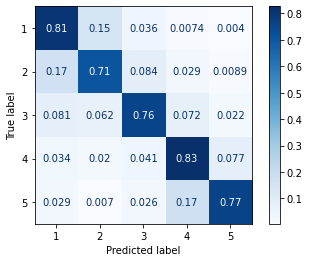


Validation Set
Accuracy: 0.549625

              precision    recall  f1-score   support

           1     0.6220    0.6988    0.6582      4867
           2     0.4694    0.4373    0.4527      4782
           3     0.4689    0.4516    0.4601      4867
           4     0.4832    0.5764    0.5257      4724
           5     0.7400    0.5836    0.6526      4760

    accuracy                         0.5496     24000
   macro avg     0.5567    0.5495    0.5499     24000
weighted avg     0.5566    0.5496    0.5499     24000



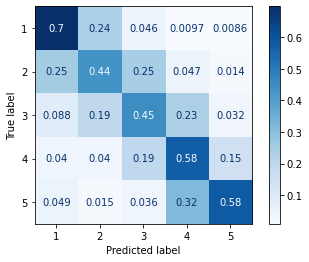


Testing Set
Accuracy: 0.5472

              precision    recall  f1-score   support

           1     0.6136    0.7037    0.6556      5883
           2     0.4807    0.4358    0.4572      6048
           3     0.4636    0.4500    0.4567      6009
           4     0.4825    0.5826    0.5278      6018
           5     0.7346    0.5677    0.6405      6042

    accuracy                         0.5472     30000
   macro avg     0.5550    0.5480    0.5475     30000
weighted avg     0.5548    0.5472    0.5471     30000



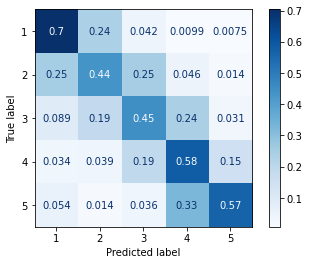


Contradictory Set
Accuracy: 0.4368932038834951

              precision    recall  f1-score   support

           1     0.4000    0.4000    0.4000        10
           2     0.6471    0.5500    0.5946        40
           3     0.3824    0.3333    0.3562        39
           4     0.1765    0.3333    0.2308         9
           5     0.3750    0.6000    0.4615         5

    accuracy                         0.4369       103
   macro avg     0.3962    0.4433    0.4086       103
weighted avg     0.4685    0.4369    0.4472       103



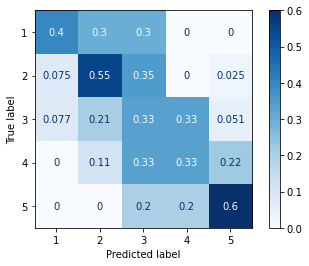


Figurative Set
Accuracy: 0.4444444444444444

              precision    recall  f1-score   support

           1     0.2500    0.1667    0.2000         6
           2     0.5714    0.7059    0.6316        17
           3     0.5000    0.3158    0.3871        19
           4     0.2308    0.5000    0.3158         6
           5     0.5000    0.3333    0.4000         6

    accuracy                         0.4444        54
   macro avg     0.4104    0.4043    0.3869        54
weighted avg     0.4648    0.4444    0.4368        54



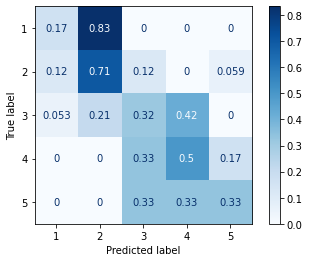


Qualifiers Set
Accuracy: 0.43243243243243246

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         1
           2     0.7000    0.4667    0.5600        15
           3     0.4211    0.4444    0.4324        18
           4     0.0000    0.0000    0.0000         1
           5     1.0000    0.5000    0.6667         2

    accuracy                         0.4324        37
   macro avg     0.4242    0.2822    0.3318        37
weighted avg     0.5427    0.4324    0.4734        37



/home/justaronee/anaconda3/envs/InnovationIndexNumba/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/justaronee/anaconda3/envs/InnovationIndexNumba/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/justaronee/anaconda3/envs/InnovationIndexNumba/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

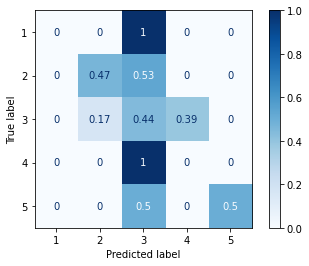

In [128]:
nb_model = evaluate_model(clf_nb, model_name="nb")